In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from xgboost import XGBRegressor

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [34]:
df_original = pd.read_excel('ACB_price.xlsx')
df_ts = df_original
df_ts.columns = ['DATE','CLOSE','OPEN','HIGH','LOW','VOLUME','CHANGE']
df_ts['VOLUME'] = df_ts['VOLUME'].str.split(".").str[0]
df_ts['VOLUME'] = df_ts['VOLUME'].astype('int')

In [35]:
df_ts.dtypes

DATE      datetime64[ns]
CLOSE            float64
OPEN             float64
HIGH             float64
LOW              float64
VOLUME             int64
CHANGE           float64
dtype: object

In [32]:
df_ts[['CHANGE_diff1','']] = df_ts[df_ts.columns[1:]].diff(1)

In [36]:
df = df_ts
sma = df['CLOSE'].rolling(9).mean()
df = df.join(sma, rsuffix='_sma')
weights = [0.1, 0.2, 0.3,0.4,0.5,0.6,0.7,0.8,0.9]
wma = df['CLOSE'].rolling(9).apply(lambda x: sum((weights*x)) / sum(weights), raw=True)
df = df.join(wma, rsuffix='_wma')
ema12 = df['CLOSE'].ewm(span=12, adjust=False).mean()
ema26 = df['CLOSE'].ewm(span=26, adjust=False).mean()
df = df.join(ema12, rsuffix='_ema12')
df = df.join(ema26, rsuffix='_ema26')
df['MACD']  = df['CLOSE_ema12'] - df['CLOSE_ema26']
def get_stochastic_oscillator(df, period=14):
    for i in range(len(df)):
        low = df.iloc[i]['CLOSE']
        high = df.iloc[i]['CLOSE']
        if i >= period:
            n = 0
            while n < period:
                if df.iloc[i-n]['CLOSE'] >= high:
                    high = df.iloc[i-n]['CLOSE']
                elif df.iloc[i-n]['CLOSE'] < low:
                    low = df.iloc[i-n]['CLOSE']
                n += 1
            df.at[i, 'best_low'] = low
            df.at[i, 'best_high'] = high
            df.at[i, 'fast_k'] = 100*((df.iloc[i]['CLOSE']-df.iloc[i]['best_low'])/(df.iloc[i]['best_high']-df.iloc[i]['best_low']))

    df['fast_d'] = df['fast_k'].rolling(3).mean().round(2)
    df['slow_k'] = df['fast_d']
    df['slow_d'] = df['slow_k'].rolling(3).mean().round(2)

    return df
get_stochastic_oscillator(df)
df['LW'] = ((df['HIGH']-df['CLOSE'])/(df['HIGH']-df['LOW']))*100

df['CLOSE_t+1'] = df['CLOSE'].diff(1)
df['CLOSE_t+1'] = np.nan
df['CLOSE_t+1'].iloc[:-1] = df['CLOSE'].iloc[1:]

def f(df):
    if df['CLOSE_t+1'] > df['CLOSE']:
        val = 1
    elif df['CLOSE_t+1'] < df['CLOSE']:
        val = 0
    else:
        val = np.nan
    return val
df['Target'] = df.apply(f, axis=1)
def acc_dist(data, trend_periods=9, open_col='OPEN', high_col='HIGH', low_col='LOW', close_col='CLOSE', vol_col='VOLUME'):
    for index, row in data.iterrows():
        if row[high_col] != row[low_col]:
            ac = ((row[close_col] - row[low_col]) - (row[high_col] - row[close_col])) / (row[high_col] - row[low_col]) * row[vol_col]
        else:
            ac = 0
        df.at[index,'acc_dist'] = ac
    data['acc_dist_ema' + str(trend_periods)] = data['acc_dist'].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    return data
acc_dist(df)
def on_balance_volume(data, trend_periods=9, close_col='CLOSE', vol_col='VOLUME'):
    for index, row in data.iterrows():
        if index > 0:
            last_obv = data.at[index - 1, 'obv']
            if row[close_col] > data.at[index - 1, close_col]:
                current_obv = last_obv + row[vol_col]
            elif row[close_col] < data.at[index - 1, close_col]:
                current_obv = last_obv - row[vol_col]
            else:
                current_obv = last_obv
        else:
            last_obv = 0
            current_obv = row[vol_col]

        df.at[index,'obv'] = current_obv
    data['obv_ema' + str(trend_periods)] = data['obv'].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    return data
on_balance_volume(df)
def price_volume_trend(data, trend_periods=9, close_col='CLOSE', vol_col='VOLUME'):
    for index, row in data.iterrows():
        if index > 0:
            last_val = data.at[index - 1, 'pvt']
            last_close = data.at[index - 1, close_col]
            today_close = row[close_col]
            today_vol = row[vol_col]
            current_val = last_val + (today_vol * (today_close - last_close) / last_close)
        else:
            current_val = row[vol_col]

        df.at[index,'pvt'] = current_val
    data['pvt_ema' + str(trend_periods)] = data['pvt'].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    return data
price_volume_trend(df)
def typical_price(data, high_col = 'HIGH', low_col = 'LOW', close_col = 'CLOSE'):
    data['typical_price'] = (data[high_col] + data[low_col] + data[close_col]) / 3
    return data
typical_price(df)

,DATE,CLOSE,OPEN,HIGH,LOW,VOLUME,CHANGE,CLOSE_sma,CLOSE_wma,CLOSE_ema12,...,LW,CLOSE_t+1,Target,acc_dist,acc_dist_ema9,obv,obv_ema9,pvt,pvt_ema9,typical_price
0,2025-04-03,24150.0,25150.0,25350.0,24150.0,39,-6.94,NaN,NaN,24150.000000,...,100.000000,25950.0,1.0,-3.900000e+01,-39.000000,39.0,39.000000,39.000000,39.000000,24550.000000
1,2025-04-02,25950.0,26100.0,26200.0,25900.0,7,-0.38,NaN,NaN,24426.923077,...,83.333333,26050.0,1.0,-4.666667e+00,-20.929825,46.0,42.684211,39.521739,39.274600,26016.666667
2,2025-04-01,26050.0,26000.0,26050.0,25900.0,3,0.19,NaN,NaN,24676.627219,...,0.000000,26000.0,0.0,3.000000e+00,-12.099631,49.0,45.014760,39.533300,39.370061,26000.000000
3,2025-03-31,26000.0,25850.0,26000.0,25800.0,9,0.19,NaN,NaN,24880.223031,...,0.000000,25950.0,0.0,9.000000e+00,-5.964234,40.0,43.556557,39.516025,39.412505,25933.333333
4,2025-03-28,25950.0,26000.0,26050.0,25850.0,9,-0.19,NaN,NaN,25044.804103,...,50.000000,26000.0,1.0,0.000000e+00,-4.507802,31.0,40.490318,39.498718,39.433557,25950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4563,2006-12-08,7745.4,7965.1,7965.1,7470.7,550,4.83,7777.711111,7729.984444,7841.236668,...,44.437702,7388.3,0.0,6.118528e+01,-33.135878,7207.0,8259.853676,-316.684752,-307.858515,7727.066667
4564,2006-12-07,7388.3,6866.5,7388.3,6866.5,274,6.75,7716.677778,7652.102222,7771.554104,...,0.000000,6921.4,0.0,2.740000e+02,-2.422290,6933.0,8127.168308,-329.317463,-310.004410,7214.366667
4565,2006-12-06,6921.4,6591.8,6921.4,6591.8,927,2.44,7608.644444,7493.046667,7640.761165,...,0.000000,6756.6,0.0,9.270000e+02,90.519939,6006.0,7915.051478,-387.898774,-317.793846,6811.533333
4566,2006-12-05,6756.6,6921.4,6921.4,6591.8,1,-2.38,7480.466667,7322.637778,7504.736370,...,50.000000,6921.4,1.0,2.759389e-15,81.467945,6005.0,7724.046330,-387.922584,-324.806720,6756.600000


In [37]:
df = df.sort_values('DATE')
size = int(len(df) * 0.8)
train, test = df[0:size], df[size:len(df)]
size_test = int(len(test) * 0.8)
valid, oot = test[0:size_test], test[size_test:len(test)]

In [38]:
train

,DATE,CLOSE,OPEN,HIGH,LOW,VOLUME,CHANGE,CLOSE_sma,CLOSE_wma,CLOSE_ema12,...,LW,CLOSE_t+1,Target,acc_dist,acc_dist_ema9,obv,obv_ema9,pvt,pvt_ema9,typical_price
4567,2006-12-04,6921.4,7196.1,7196.1,6866.5,1,-3.08,7376.711111,7210.824444,7414.992313,...,83.343447,NaN,NaN,-6.668689e-01,73.254464,6006.0,7552.241697,-387.898193,-331.115867,6994.666667
4566,2006-12-05,6756.6,6921.4,6921.4,6591.8,1,-2.38,7480.466667,7322.637778,7504.736370,...,50.000000,6921.4,1.0,2.759389e-15,81.467945,6005.0,7724.046330,-387.922584,-324.806720,6756.600000
4565,2006-12-06,6921.4,6591.8,6921.4,6591.8,927,2.44,7608.644444,7493.046667,7640.761165,...,0.000000,6756.6,0.0,9.270000e+02,90.519939,6006.0,7915.051478,-387.898774,-317.793846,6811.533333
4564,2006-12-07,7388.3,6866.5,7388.3,6866.5,274,6.75,7716.677778,7652.102222,7771.554104,...,0.000000,6921.4,0.0,2.740000e+02,-2.422290,6933.0,8127.168308,-329.317463,-310.004410,7214.366667
4563,2006-12-08,7745.4,7965.1,7965.1,7470.7,550,4.83,7777.711111,7729.984444,7841.236668,...,44.437702,7388.3,0.0,6.118528e+01,-33.135878,7207.0,8259.853676,-316.684752,-307.858515,7727.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,2021-07-29,27320.0,26760.0,27360.0,26640.0,9,3.02,28595.555556,28406.222222,28260.846641,...,5.555556,26520.0,0.0,8.000000e+00,4.542458,-171.0,-208.306212,40.835057,40.310541,27106.666667
917,2021-07-30,28920.0,27440.0,28920.0,27440.0,43,5.86,28760.000000,28694.222222,28431.909666,...,0.000000,27320.0,0.0,4.300000e+01,4.158287,-162.0,-212.451346,41.332983,40.252261,28426.666667
916,2021-08-02,28440.0,28400.0,28800.0,28280.0,10,-1.66,28684.444444,28647.111111,28343.165969,...,69.230769,28920.0,1.0,-3.846154e+00,-0.157459,-205.0,-218.057052,40.607244,40.132181,28506.666667
915,2021-08-03,28640.0,28360.0,28640.0,28000.0,10,0.70,28666.666667,28692.444444,28325.559782,...,0.000000,28440.0,0.0,1.000000e+01,0.252396,-195.0,-219.507835,40.677077,40.079396,28426.666667


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [11]:
ACB_recent = diff_1['CLOSE']
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# define input sequence
# choose a number of time steps
n_steps = 10
# split into samples
X,y= split_sequence(ACB_recent, n_steps)

In [12]:
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
size_test = int(len(test) * 0.8)
valid, oot = test[0:size_test], test[size_test:len(test)]

size1 = int(len(y) * 0.8)
train1, test1 = y[0:size], y[size:len(y)]
size_test1 = int(len(test1) * 0.8)
valid1, oot1 = test1[0:size_test], test1[size_test:len(test)]

In [13]:
X_train = np.hstack(train).reshape(len(train),n_steps,1)
y_train = np.hstack(train1).reshape(len(train1),1)
X_valid = np.hstack(valid).reshape(len(valid),n_steps,1)
y_valid = np.hstack(valid1).reshape(len(valid1),1)
print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape)

(3645, 10, 1) (3645, 1) (729, 10, 1) (729, 1)


In [14]:
input_length = X_train.shape[1]
input_dim = X_train.shape[2]
# Output dimensions is the shape of a single output vector
# In this case it's just 1, but it could be more
output_dim = len(y_train[0])
print(input_length,input_dim)

10 1


In [15]:
N_VALIDATION = len(y_valid)
N_TRAIN = len(y_train)
#BUFFER_SIZE = int(1e4)
BATCH_SIZE = 16
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
print(STEPS_PER_EPOCH)

227


In [16]:
import pathlib
import shutil
import tempfile
from tensorflow.keras import layers
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [96]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='loss',mode="min",patience=50),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [123]:
def compile_and_fit(model, name, max_epochs=5000):
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanAbsolutePercentageError()])

  model.summary()

  history = model.fit(
    X_train, y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    callbacks=get_callbacks(name),
    validation_data=(X_valid, y_valid),
    verbose=0,
    batch_size=BATCH_SIZE)
  return history

In [125]:
tiny_model = Sequential()
#tiny_model.add(LSTM(126, activation='silu', input_shape=(n_steps, 1),return_sequences=True))
#tiny_model.add(LSTM(126, activation='silu', input_shape=(n_steps, 1),return_sequences=True))
#tiny_model.add(LSTM(256, activation='silu', input_shape=(n_steps, 1),return_sequences=True))
tiny_model.add(LSTM(64, activation='silu', input_shape=(n_steps, 1)))
tiny_model.add(Dense(1))

In [122]:
tiny_model.get_weights()

[array([[-0.02913721,  0.09483859,  0.06230225, -0.11179002, -0.02253377,
          0.10164042,  0.06745388,  0.13442452, -0.01399408,  0.09391685,
          0.01268685, -0.06531632,  0.04696476,  0.0340824 , -0.10921568,
          0.05469456,  0.05233169, -0.06882904,  0.00721505, -0.08985205,
         -0.0901444 ,  0.02573709,  0.09714769, -0.08955832, -0.04045936,
          0.1019112 , -0.08600958, -0.15191095,  0.0433926 ,  0.07165569,
          0.05529881,  0.13476415, -0.12037579, -0.02907214, -0.0080661 ,
          0.01176946, -0.14588848, -0.12440598, -0.12635851, -0.00996804,
          0.11516868, -0.13929546, -0.02085133, -0.09567708, -0.10481729,
         -0.05751246, -0.03780804, -0.07404711, -0.09439892,  0.12673442,
         -0.10632419,  0.0605344 ,  0.05018908,  0.07193069, -0.08835926,
          0.08462629, -0.06902557,  0.04167084, -0.11057059, -0.08310086,
          0.11399646, -0.04352942, -0.11910714, -0.10419086,  0.06935948,
          0.01718506, -0.05133914, -0.

In [126]:
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, loss:66320.1797,  mean_absolute_percentage_error:689204480.0000,  mean_squared_error:66320.1797,  val_loss:48275.3359,  val_mean_absolute_percentage_error:410741632.0000,  val_mean_squared_error:47901.1133,  
..................................................................

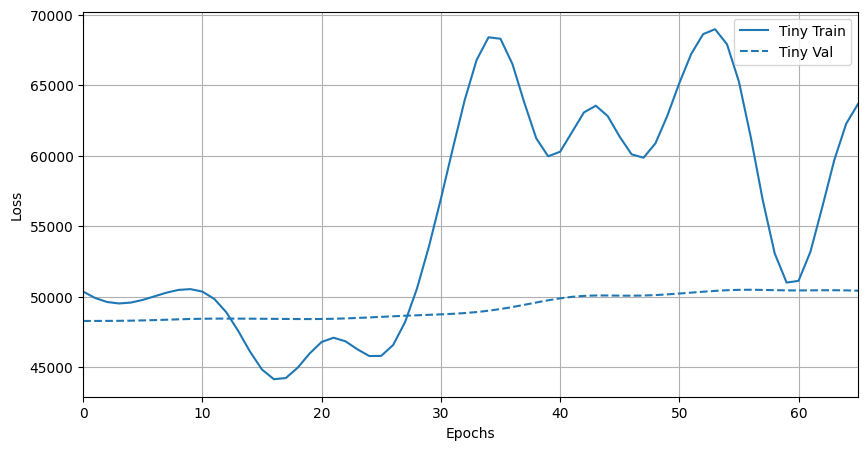

In [127]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(size_histories)

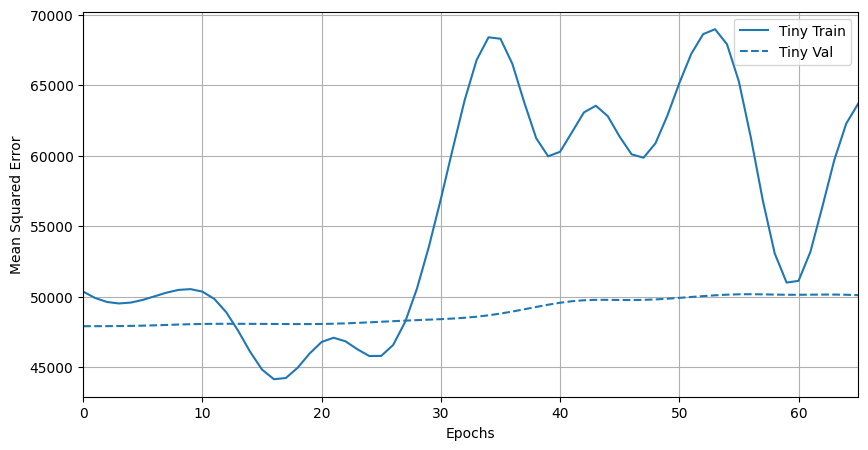

In [128]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_squared_error', smoothing_std=10)
plotter.plot(size_histories)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


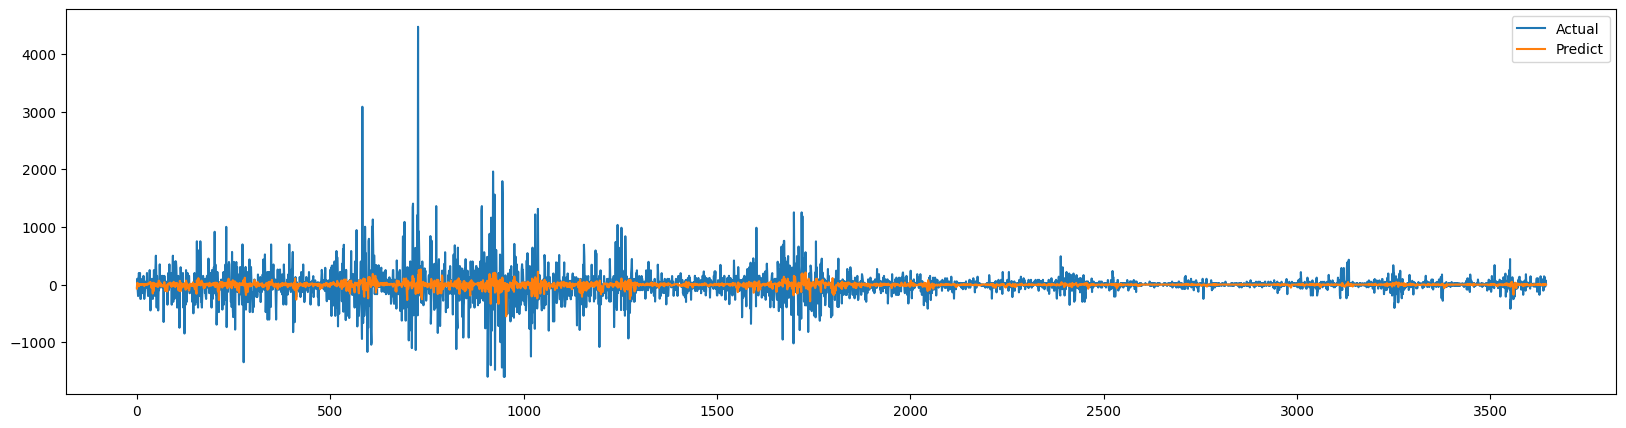

In [129]:
X_train = np.hstack(train).reshape(len(train),n_steps,1)
yhat = pd.DataFrame(tiny_model.predict(X_train))
yhat.columns = ['CLOSE']

df_actual = pd.DataFrame(train1,columns=['actual'])
df_actual

plt.figure(figsize=(20,5))
plt.plot(df_actual,label="Actual")
plt.plot(yhat ,label="Predict")
plt.legend()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


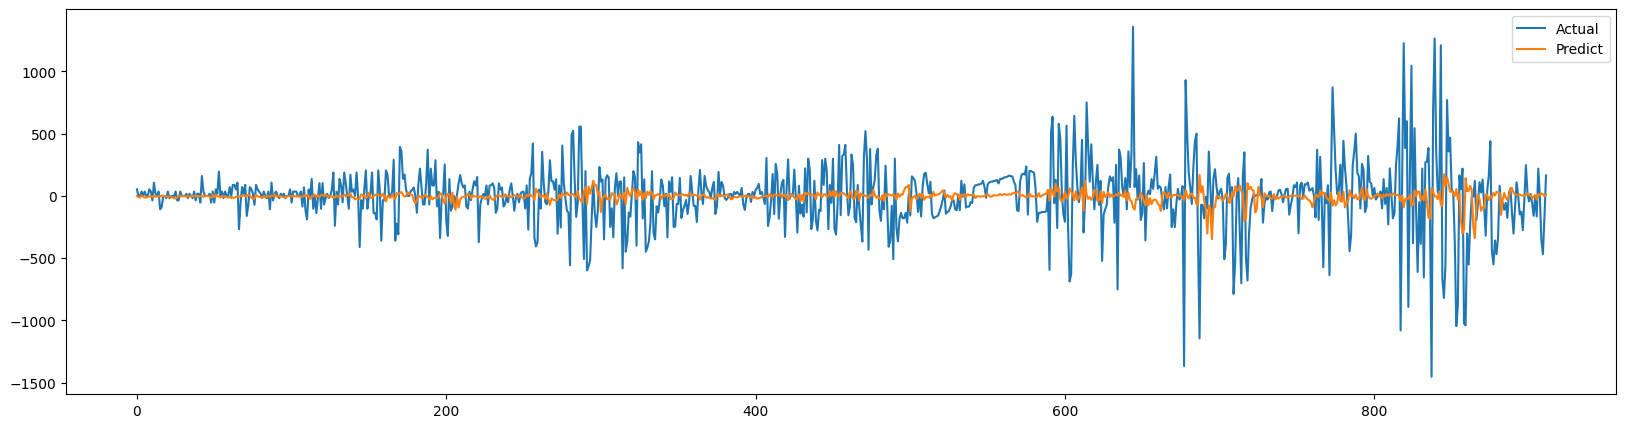

In [130]:
X_test = np.hstack(test).reshape(len(test),n_steps,1)
yhat = pd.DataFrame(tiny_model.predict(X_test))
yhat.columns = ['CLOSE']

df_actual = pd.DataFrame(test1,columns=['actual'])
df_actual

plt.figure(figsize=(20,5))
plt.plot(df_actual,label="Actual")
plt.plot(yhat ,label="Predict")
plt.legend()
plt.show()